<a href="https://colab.research.google.com/github/danunter/hw/blob/main/hw7_VGGNet_cats%26dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
# Define the paths to the train and validation folders
train_path = "/content/drive/MyDrive/AI_course/hw5/cats_and_dogs_filtered/cats_and_dogs_filtered/train"
validation_path = '/content/drive/MyDrive/AI_course/hw5/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

#hyperparams
img_width=150
img_height=150
num_epochs = 25
learning_rate=0.001
batch_size=32

pytorch


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
    ]),
}

# Load your own dataset
image_datasets = {
    'train': datasets.ImageFolder(root=train_path, transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=validation_path, transform=data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)
}

# Use VGG16 pre-trained model
model = models.vgg16(pretrained=True)

# Freeze all layers except the last fully connected layer
for param in model.features.parameters():
    param.requires_grad = False

# Modify the last fully connected layer for binary classification (cats and dogs)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[6].parameters(), lr=learning_rate, momentum=0.9)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0
        total_samples = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_accuracy = corrects.double() / total_samples

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_accuracy_history.append(epoch_accuracy.item())
        else:
            val_loss_history.append(epoch_loss)
            val_accuracy_history.append(epoch_accuracy.item())

        print(f'Epoch {epoch + 1}/{num_epochs} | {phase} Loss: {epoch_loss:.4f} | {phase} Accuracy: {epoch_accuracy:.4f}')

# --------------------------------------------------------------------
# Get the number of input features for the last fully connected layer
num_features = model.classifier[6].in_features
# Define the last fully connected layer with 2 output units (binary classification)
last_fc_layer = nn.Linear(num_features, 2)
# Calculate the number of parameters for the last fully connected layer
num_parameters_last_layer = last_fc_layer.weight.numel() + last_fc_layer.bias.numel()
print(f"Pytorch- Number of parameters in the last fully connected layer: {num_parameters_last_layer}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/25 | train Loss: 0.2371 | train Accuracy: 0.8945
Epoch 1/25 | val Loss: 0.1408 | val Accuracy: 0.9400
Epoch 2/25 | train Loss: 0.1518 | train Accuracy: 0.9365
Epoch 2/25 | val Loss: 0.1331 | val Accuracy: 0.9420
Epoch 3/25 | train Loss: 0.1496 | train Accuracy: 0.9375
Epoch 3/25 | val Loss: 0.1308 | val Accuracy: 0.9450
Epoch 4/25 | train Loss: 0.1380 | train Accuracy: 0.9370
Epoch 4/25 | val Loss: 0.1272 | val Accuracy: 0.9460
Epoch 5/25 | train Loss: 0.1296 | train Accuracy: 0.9385
Epoch 5/25 | val Loss: 0.1310 | val Accuracy: 0.9480
Epoch 6/25 | train Loss: 0.1167 | train Accuracy: 0.9530
Epoch 6/25 | val Loss: 0.1270 | val Accuracy: 0.9480
Epoch 7/25 | train Loss: 0.1031 | train Accuracy: 0.9590
Epoch 7/25 | val Loss: 0.1191 | val Accuracy: 0.9450
Epoch 8/25 | train Loss: 0.1114 | train Accuracy: 0.9535
Epoch 8/25 | val Loss: 0.1253 | val Accuracy: 0.9460
Epoch 9/25 | train Loss: 0.1154 | train Accuracy: 0.9490
Epoch 9/25 | val Loss: 0.1229 | val Accuracy: 0.9480
Epoch 10/2

TensorFlow


In [86]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# Create a training dataset using tf.keras.preprocessing.image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="int",
    class_names=["cats", "dogs"],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_width, img_height),  # Adjust the size according to your needs
    shuffle=True,
    seed=42,
)

# Create a validation dataset using tf.keras.preprocessing.image_dataset_from_directory
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_path,
    labels="inferred",
    label_mode="int",
    class_names=["cats", "dogs"],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_width, img_height),  # Adjust the size according to your needs
    shuffle=False,  # No need to shuffle validation data
    seed=42,
)

# Define VGGNet model using TensorFlow
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with additional Dense layers
tf_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # Change from Flatten to GlobalAveragePooling2D
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the TensorFlow model
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train TensorFlow model
tf_history = tf_model.fit(train_dataset, epochs=num_epochs, validation_data=validation_dataset)

# ---------------------------------------------------------------
# Calculate number of trainable parameters in the last two layers approach
total_trainable_parameters_last_two_layers = sum(layer.count_params() for layer in tf_model.layers[-2:] if layer.trainable)
print(f"Total number of trainable parameters in the last two layers: {total_trainable_parameters_last_two_layers}")

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Epoch 1/25
63/63 [==============================] - 10s 126ms/step - loss: 0.9542 - accuracy: 0.8110 - val_loss: 0.3035 - val_accuracy: 0.9080
Epoch 2/25
63/63 [==============================] - 7s 109ms/step - loss: 0.2019 - accuracy: 0.9295 - val_loss: 0.2501 - val_accuracy: 0.9150
Epoch 3/25
63/63 [==============================] - 7s 102ms/step - loss: 0.1310 - accuracy: 0.9570 - val_loss: 0.2323 - val_accuracy: 0.9240
Epoch 4/25
63/63 [==============================] - 7s 107ms/step - loss: 0.0966 - accuracy: 0.9665 - val_loss: 0.2203 - val_accuracy: 0.9310
Epoch 5/25
63/63 [==============================] - 7s 109ms/step - loss: 0.0693 - accuracy: 0.9795 - val_loss: 0.2220 - val_accuracy: 0.9320
Epoch 6/25
63/63 [==============================] - 8s 110ms/step - loss: 0.0521 - accuracy: 0.9855 - val_loss: 0.2286 - val_accuracy: 0.9350
Epoch 7/25
63/63 [==============================] - 7s 109ms/step

comparison

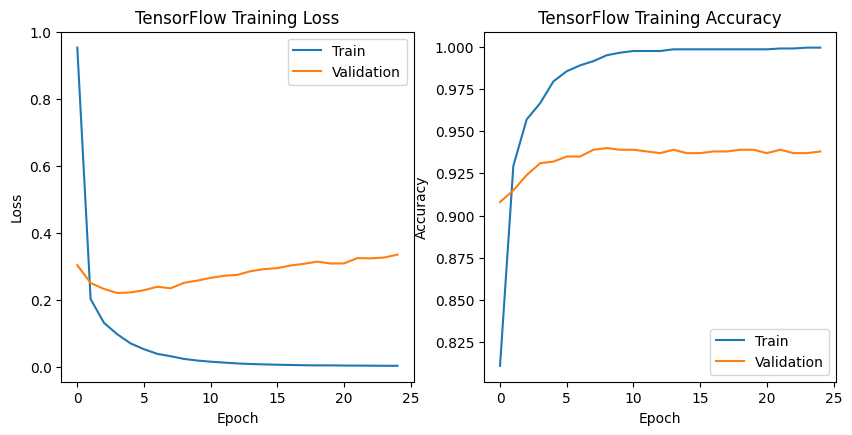

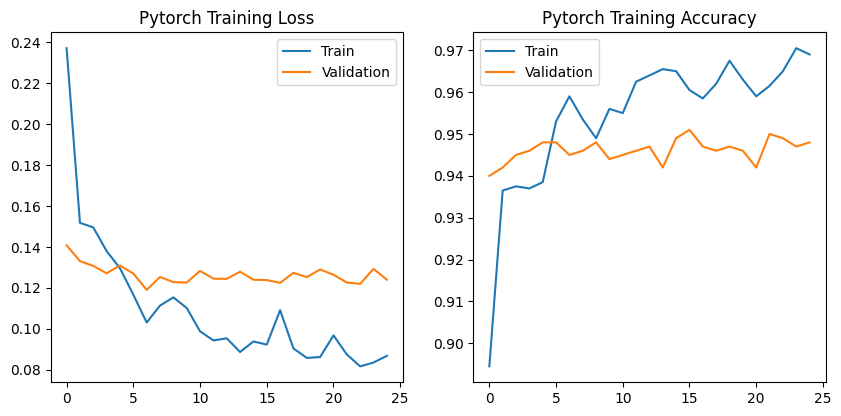

In [87]:

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(tf_history.history['loss'], label='Train')
plt.title('TensorFlow Training Loss')
plt.plot(tf_history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(tf_history.history['accuracy'], label='Train')
plt.title('TensorFlow Training Accuracy')
plt.plot(tf_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss and accuracy graphs on CPU
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 3)
plt.plot(train_loss_history, label='Train')
plt.title('Pytorch Training Loss')
plt.plot(val_loss_history, label='Validation')
plt.legend()

plt.subplot(2, 2, 4)
plt.title('Pytorch Training Accuracy')
plt.plot(train_accuracy_history, label='Train')
plt.plot(val_accuracy_history, label='Validation')
plt.legend()




check how many trainable parameters each model learns

In [83]:
# pytorch model
# Use VGG16 pre-trained model
model = models.vgg16(pretrained=True)
# Freeze all layers except the last fully connected layer
for param in model.features.parameters():
    param.requires_grad = False
# Modify the last fully connected layer for binary classification (cats and dogs)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[6].parameters(), lr=learning_rate, momentum=0.9)
# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Get the number of input features for the last fully connected layer
num_features = model.classifier[6].in_features
# Define the last fully connected layer with 2 output units (binary classification)
last_fc_layer = nn.Linear(num_features, 2)
# Calculate the number of parameters for the last fully connected layer
num_parameters_last_layer = last_fc_layer.weight.numel() + last_fc_layer.bias.numel()
print(f"Pytorch- Number of parameters in the last fully connected layer: {num_parameters_last_layer}")

# Define VGGNet model using TensorFlow
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
# --------------------------------------------------------------------------------------------------------------
# TensorFlow model
# Create a new model with additional Dense layers
tf_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # Change from Flatten to GlobalAveragePooling2D
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
# Compile the TensorFlow model
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Calculate number of trainable parameters in the last two layers approach
total_trainable_parameters_last_two_layers = sum(layer.count_params() for layer in tf_model.layers[-2:] if layer.trainable)
print(f"Total number of trainable parameters in the last two layers: {total_trainable_parameters_last_two_layers}")


Pytorch- Number of parameters in the last fully connected layer: 8194
Total number of trainable parameters in the last two layers: 8242


note: i did get better results with a bigger layer of the tf model (Dense(16) vs Dense(256)) but for some reason the number of trainable parameters is different in each model and i think that wasnt desired, though i couldnt find a way to fix it